# Regularized Linear Regression and Bias v.s. Variance

# Introduction

Regularized linear regression will be implemented and it will be used to study models with different bias-variance properties.

# Regularized Linear Regression

Regularized linear regression will be implemented to predict the amount of water flowing out of a dam using the change of water level in a reservoir. Several diagnostics of debugging learning algorithms and the effects of bias v.s. variance will be examined.

## Visualizing the Dataset

The loaded data with the `loadmat` function from `scipy` library contain historical records on the change in the water level, x, and the amount of water flowing out of the dam, y. A scatter plot of y against x is shown in Figure 1.

This dataset is divided into three parts:

* A training set that the model will learn on: X, y
* A cross validation set for determining the regularization parameter: Xval, yval
* A test set for evaluating performance. These are “unseen” examples which the model will not see during training: Xtest, ytest

First, linear regression will be modelled and it will be used to fit a straight line to the data and plot learning curves. Following that, a polynomial regression will be modelled to find a better fit to the data.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

data = loadmat('ex5data1.mat')
for k in data:
    print(k)

__header__
__version__
__globals__
X
y
Xtest
ytest
Xval
yval


Shapes of X(12, 1) and y(12, 1)
Shapes of Xval(21, 1) and yval(21, 1)
Shapes of Xtest(21, 1) and ytest(21, 1)


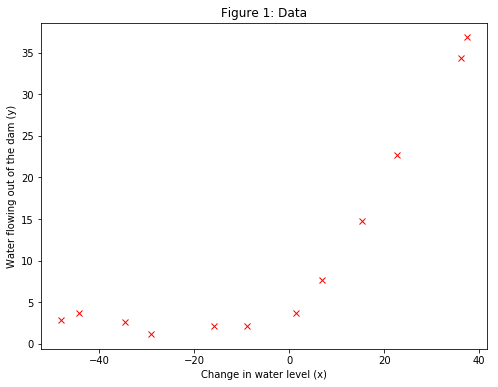

In [2]:
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']

print("Shapes of X{} and y{}".format(X.shape, y.shape))
print("Shapes of Xval{} and yval{}".format(Xval.shape, yval.shape))
print("Shapes of Xtest{} and ytest{}".format(Xtest.shape, ytest.shape))

plt.figure(figsize=(8, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 1: Data')
plt.plot(X, y, 'rx')

## Regularized Linear Regression Cost Function

The regularized linear regression has the following cost function:

$$J(\theta)=\frac{1}{2m}\left( \sum_{i=1}^{m}\left(h_\theta\left(x^{(i)}\right)-y^{(i)}\right)^2\right)+\frac{\lambda}{2m}\left( \sum_{j=1}^{n}\theta_j^2\right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost $J$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that the $\theta_0$ term should never be regularized. Running the cost function with theta initialized at $[1, 1]$ the output will be about $303.993$.

## Regularized Linear Regression Gradient

Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_j$ is defined as

$$\frac{\partial{J(\theta)}}{\partial{\theta_0}} = \frac{1}{m} \sum_{i=1}^{m}\left( h_\theta\left(x^{(i)}\right)-y^{(i)}\right)x_j^{(i)} \quad \text{for} \quad j=0$$

$$\frac{\partial{J(\theta)}}{\partial{\theta_j}} = \left(\frac{1}{m} \sum_{i=1}^{m}\left( h_\theta\left(x^{(i)}\right)-y^{(i)}\right)x_j^{(i)}\right)+\frac{\lambda}{m}\theta_j \quad \text{for} \quad j\geq1$$

Running the gradient function using theta initialized at $[1, 1]$ the gradient will be $[-15.30, 598.250]$.

In [3]:
# Insert the 1's column.
X_with_1s = np.insert(X, 0, 1, axis=1)
Xval_with_1s = np.insert(Xval, 0, 1, axis=1)

# Create a function to compute cost and gradient.
def linearRegCostFunction(X, y, theta, lambda_coef):
    """
    Computes cost and gradient for regularized
    linear regression with multiple variables.
    Args:
        X: array (m, number of features+1)
        y: array (m, 1)
        theta: array (number of features+1, 1)
        lambda_coef: float
    Returns:
        J: float
        grad: vector array
    """
    # Get the number of training examples, m.
    m = len(X)
    
    # Ensure theta shape(number of features+1, 1).
    theta = theta.reshape(-1, y.shape[1])
    
    #############################################################
    ###################### Cost Computation #####################
    #############################################################
    # Compute the cost.
    unreg_term = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    
    # Note that we should not regularize the theta_0 term!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:len(theta)]))
    
    cost = unreg_term + reg_term
    
    #############################################################
    #################### Gradient Computation ###################
    #############################################################
    # Initialize grad.
    grad = np.zeros(theta.shape)

    # Compute gradient for j >= 1.
    grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y) + (lambda_coef / m ) * theta
    
    # Compute gradient for j = 0,
    # and replace the gradient of theta_0 in grad.
    unreg_grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y)
    grad[0] = unreg_grad[0]

    return (cost, grad.flatten())

# Initialize theta at [1, 1].
theta = np.array([[1], [1]])

# Run the cost function with theta [1, 1] and lambda_coef = 1.
(cost, grad) = linearRegCostFunction(X_with_1s, y, theta, 1)
print('Cost and Gradient at theta = [1, 1]:', (cost, grad))

Cost and Gradient at theta = [1, 1]: (303.99319222026429, array([ -15.30301567,  598.25074417]))


## Fitting Linear Regression

Once the cost function and gradient are working correctly, the optimal values of $\theta$ in `trainLinearReg` should be computed. This training function uses the `minimize` function from `scipy` to optimize the cost function.
In this part, the regularization parameter $\lambda$ is set to zero. Because the current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. Later, polynomial regression with regularization will be used.

In [4]:
from scipy.optimize import minimize

def trainLinearReg(X, y, lambda_coef):
    """
    Trains linear regression using the dataset (X, y)
    and regularization parameter lambda_coef.
    Returns the trained parameters theta.
    Args:
        X: array (m, number of features+1)
        y: array (m, 1)
        lambda_coef: float
    Returns:
        theta: array (number of features+1, )
    """
    # Initialize Theta.
    initial_theta = np.zeros((X.shape[1], 1))
    
    # Create "short hand" for the cost function to be minimized.
    def costFunction(theta):
        return linearRegCostFunction(X, y, theta, lambda_coef)
    
    # Now, costFunction is a function that takes in only one argument.
    results = minimize(fun=costFunction,
                       x0=initial_theta,
                       method='CG',
                       jac=True,
                       options={'maxiter':200})
    theta = results.x

    return theta

# Train linear regression with lambda_coef = 0.
theta = trainLinearReg(X_with_1s, y, 0)
theta

array([ 13.08790351,   0.36777923])

* **Note:** Plotting the best fit line, results in the Figure 2 image. The best fit line depicts that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug the learning algorithm, it is not always easy to visualize the data and model. Next, a function will be implemented to generate learning curves that can help to debug the learning algorithm even if it is not easy to visualize the data.

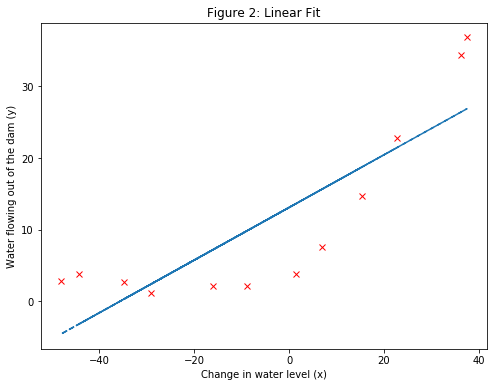

In [5]:
plt.figure(figsize=(8, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 2: Linear Fit')
plt.plot(X, y, 'rx')
plt.plot(X, np.dot(np.insert(X, 0, 1, axis=1), theta), '--')

# Bias-Variance

An important concept in machine learning is the **bias-variance tradeoff**. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

Next, training and test errors will be plotted on a learning curve to diagnose bias-variance problems.

## Learning Curves

Learning curves which are useful in debugging learning algorithms will be generated. A learning curve plots training and cross validation error as a function of training set size. The code in `learningCurve` will return a vector of errors for the training set and cross validation set.

To plot the learning curve, a training and cross validation set error for different training set sizes is required. To obtain different training set sizes, different subsets of the original training set $X$ should be used. Specifically, for a training set size of $i$, the first $i$ examples (i.e., $X(1:i,:)$ and $y(1:i)$) should be used.

The `trainLinearReg` function can be used to find the $\theta$ parameters. Note that the $\lambda$ is passed as a parameter to the `learningCurve` function. After learning the $\theta$ parameters, the error on the training and cross validation sets will be computed. The training error for a dataset is defined as

$$J_{train}(\theta)=\frac{1}{2m}\left( \sum_{i=1}^{m}\left(h_\theta\left(x^{(i)}\right)-y^{(i)}\right)^2\right)$$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use the existing cost function and set $\lambda$ to $0$ only when using it to compute the training error and cross validation error. When the training set error is going to be computed, it must be computed on the training subset (i.e., $X(1:n,:)$ and $y(1:n)$) (instead of the entire training set). However, for the cross validation error, it is computed over the entire cross validation set. The computed errors will be stored in the vectors `error_train` and `error_val`. The learning curves will be printed and the errors against the number of training examples will be plotted (Figure 3).

In [6]:
# Create a function that generates the errors.
def learningCurve(X, y, Xval, yval, lambda_coef):
    """
    Generates the train and cross validation set errors needed 
    to plot a learning curve. In particular, it returns two
    vectors of the same length - error_train and error_val.
    Then, error_train(i) contains the training error for
    i examples (and similarly for error_val(i)).
    Note:
        We should evaluate the training error on the first
        i training examples (i.e., X(1:i, :) and y(1:i)), but
        for the cross-validation error, we should instead
        evaluate on the entire cross validation set (Xval, yval).
    Args:
        X: array (m, number of features+1)
        y: array (m, 1)
        Xval: array (s, number of features+1)
        yval: array (s, 1)
        lambda_coef: float
    Returns:
        error_train: array (m, 1)
        error_val: array (m, 1)
    """
    # Get the number of training examples, m.
    m = len(X)
    
    # Initialize train and cross validation set errors.
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for i in range(1, m+1):
        # Train with different subsets of the training
        # set X to obtain the theta parameters.
        theta = trainLinearReg(X[:i], y[:i], lambda_coef)
        
        # Compute train/cross validation errors, storing
        # the result in error_train and error_val.
        # Note that to compute the errors, we should call
        # the function with the lambda_coef set to 0.
        error_train[i-1] = linearRegCostFunction(X[:i], y[:i], theta, 0)[0]
        error_val[i-1] = linearRegCostFunction(Xval, yval, theta, 0)[0]
        
    return error_train, error_val

In Figure 3, it is clear that both the train error and cross validation error are high when the number of training examples is increased. This reflects a **high bias** problem in the model. The linear regression model is too simple and is unable to fit the dataset well. Next, a polynomial regression will be implemented to fit a better model for this dataset.

# Training Examples	Train Error	Cross Validation Error

1			0.000000	205.121096

2			0.000000	110.300366

3			3.286595	45.010232

4			2.842678	48.368911

5			13.154049	35.865141

6			19.443963	33.829957

7			20.098522	31.970987

8			18.172859	30.862446

9			22.609405	31.135998

10			23.261462	28.936207

11			24.317250	29.551432

12			22.373906	29.433818



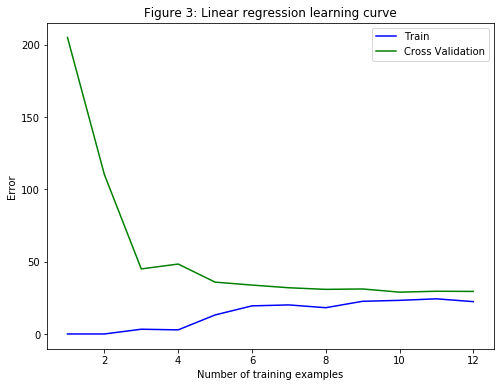

In [7]:
m = len(X)

# Get the errors with lambda_coef set to 0.
error_train, error_val = learningCurve(X_with_1s, y,
                                       Xval_with_1s, yval, 0)

print('# Training Examples\tTrain Error\tCross Validation Error\n')
for i in range(m):
    print('{}\t\t\t{:f}\t{:f}\n'.format(i+1, float(error_train[i]), float(error_val[i])))

plt.figure(figsize=(8, 6))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Figure 3: Linear regression learning curve')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

# Polynomial regression

The problem with the linear model was that it was too simple for the data and resulted in underfitting (high bias). Next, this problem will be addressed by adding more features. For use polynomial regression, the hypothesis has the form:

$$h_{\theta}(x)=\theta_0+\theta_1*\left(\text{waterLevel}\right)+\theta_2*\left(\text{waterLevel}\right)^2+\cdots+\theta_p*\left(\text{waterLevel}\right)^p$$
$$h_{\theta}(x)=\theta_0+\theta_1x_1+\theta_2x_2+\cdots+\theta_px_p$$

Notice that by defining $x_1=\left(\text{waterLevel}\right)$, $x_2=\left(\text{waterLevel}\right)^2$,..., $x_p=\left(\text{waterLevel}\right)^p$, a linear regression model is obtained where the features are the various powers of the original value $\left(\text{waterLevel}\right)$.

The code in `polyFeatures` adds more features using the higher powers of the existing feature $x$ in the dataset. This function maps the original training set $X$ of size $(m, 1)$ into its higher powers. Specifically, when a training set $X$ of size $(m, 1)$ is passed into the function, the function returns a $(m, p)$ matrix `X_poly`, where column 1 holds the original values of $X$, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that there is no need to account for the zero-eth power in this function.

In [8]:
# Create a function that maps the original X into its higher powers.
def polyFeatures(X, p):
    """
    Takes a data set X and maps each example into its polynomial
    features, where X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p]
    Args:
        X: array (m, 1)
        p: int > 1
    Returns:
        X_poly: array (m, p)
    """
    # Initialize X_poly.
    X_poly = X

    # Iterate over the polynomial power.
    for i in range(1, p):
        # Add the i-th power column in X.
        X_poly = np.column_stack((X_poly, np.power(X, i+1)))   
    
    return X_poly

## Learning Polynomial Regression

After adding more features with `polyFeatures`, a polynomial regression model will be trained using the linear regression cost function.

Note that even though there are polynomial terms in the feature vector, the solution is still a linear regression optimization problem. The polynomial terms have been simply turned into features that they can be used for linear regression. The same cost function and gradient are going to be applied.

A polynomial degree of $8$ will be used. It turns out that running the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8=40^8=6.5\text{x}10^{12}$). Therefore, feature normalization should be applied.

Before learning the parameters $\theta$ for the polynomial regression, `featureNormalize` will be implemented, which will normalize the features of the training set, storing the `mu` and `sigma` parameters separately.

After learning the parameters $\theta$, the following two plots (Figure 4, 5) were generated for polynomial regression with $\lambda=0$.

From Figure 4, it can be seen that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized $\left(\lambda=0\right)$ model, it can be seen that the learning curve (Figure 5) shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

Normalized Training Example 1:
[ 1.         -0.8389201   0.0013142  -0.25896174 -0.34156482  0.09754927
 -0.45519664  0.26677343 -0.46887381]


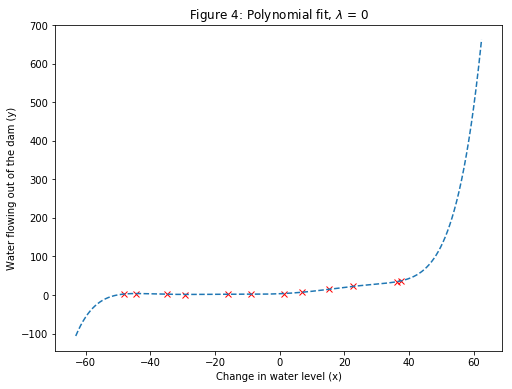

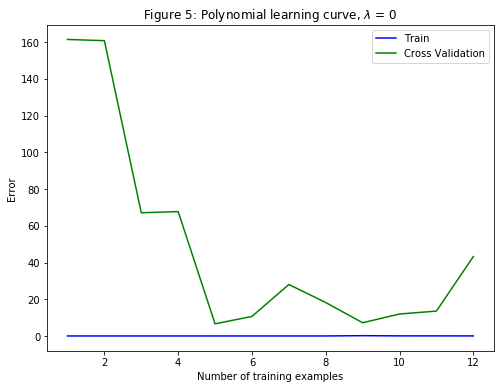

In [9]:
# Create a function that normalizes the features of X.
def featureNormalize(X):
    """
    Returns a normalized version of X where the mean value
    of each feature is 0 and the standard deviation is 1.
    Args:
        X: array (m, number of features)
    Returns:
        X: array (m, number of features)
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

p = 8

# Map X onto Polynomial Features and Normalize.
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly) # Normalize
X_poly = np.insert(X_poly, 0, 1, axis=1) # Add Ones

# Map X_poly_test and normalize (using mu and sigma).
X_poly_test = polyFeatures(Xtest, p)
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test / sigma
X_poly_test = np.insert(X_poly_test, 0, 1, axis=1) # Add Ones

# # Map X_poly_val and normalize (using mu and sigma).
X_poly_val = polyFeatures(Xval, p)
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val / sigma
X_poly_val = np.insert(X_poly_val, 0, 1, axis=1) # Add Ones

print('Normalized Training Example 1:')
print(X_poly[1, :])

# Create a function to plot a polynomial regression fit.
def plotFit(min_x, max_x, mu, sigma, theta, p):
    """
    Plots the learned polynomial fit with power p
    and feature normalization (mu, sigma).
    Also works with linear regression.
    Args:
        X: array (m, number of features)
    Returns:
        X: array (m, number of features)
    """
    # We plot a range slightly bigger than the min and max
    # values to get an idea of how the fit will vary outside
    # the range of the data points.
    x = np.array(np.arange(min_x - 15, max_x + 25, 0.05))

    # Map the X values.
    X_poly = polyFeatures(x, p)
    X_poly = X_poly - mu
    X_poly = X_poly / sigma

    # Add ones.
    X_poly = np.insert(X_poly, 0, 1, axis=1)

    # Plot
    plt.plot(x, np.dot(X_poly, theta), '--')


# Train linear regression with lambda_coef = 0.
theta = trainLinearReg(X_poly, y, 0)

plt.figure(figsize=(8, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 4: Polynomial fit, $\lambda$ = 0')
plt.plot(X, y, 'rx')
plotFit(min(X), max(X), mu, sigma, theta, p)

# Get the errors with lambda_coef set to 0.
error_train, error_val = learningCurve(X_poly, y,
                                       X_poly_val, yval, 0)

plt.figure(figsize=(8, 6))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Figure 5: Polynomial learning curve, $\lambda$ = 0')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

One way to combat the overfitting (high-variance) problem is to add regularization to the model. Next, different $\lambda$ parameters will be tested to see how regularization can lead to a better model.

## Adjusting the Regularization Parameter

In this section, it will be observed how the regularization parameter affects the bias-variance of regularized polynomial regression. The $\lambda$ parameter will be modified and the values $1,100$ will be tested. For each of these values, a polynomial fit to the data and a learning curve will be generated.

For $\lambda=1$, we see a polynomial fit that follows the data trend well (Figure 6) and a learning curve (Figure 7) showing that both the cross validation and training error converge to a relatively low value. This shows that the $\lambda=1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

For $\lambda=100$, the polynomial fit (Figure 8) does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

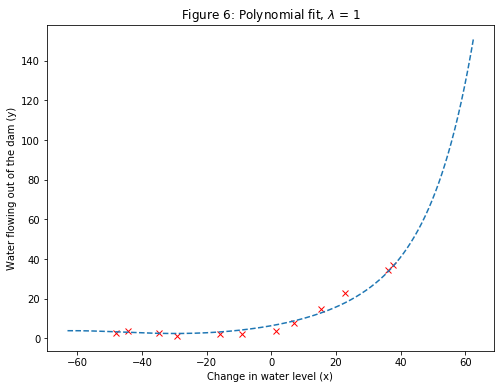

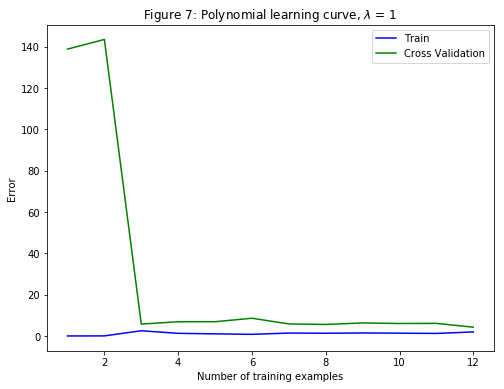

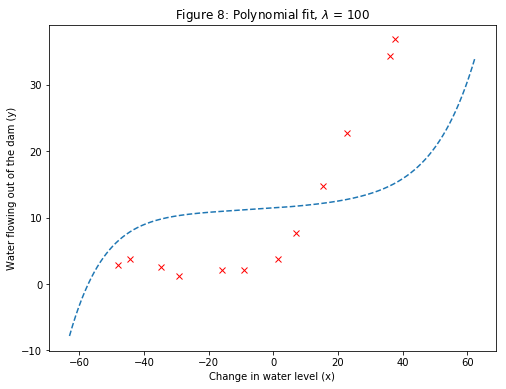

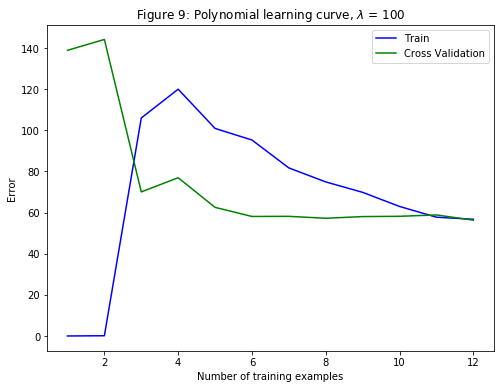

In [10]:
p = 8

# Train linear regression with lambda_coef = 1.
theta = trainLinearReg(X_poly, y, 1)

plt.figure(figsize=(8, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 6: Polynomial fit, $\lambda$ = 1')
plt.plot(X, y, 'rx')
plotFit(min(X), max(X), mu, sigma, theta, p)

# Get the errors with lambda_coef set to 1.
error_train, error_val = learningCurve(X_poly, y,
                                       X_poly_val, yval, 1)

plt.figure(figsize=(8, 6))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Figure 7: Polynomial learning curve, $\lambda$ = 1')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

# Train linear regression with lambda_coef = 100.
theta = trainLinearReg(X_poly, y, 100)

plt.figure(figsize=(8, 6))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Figure 8: Polynomial fit, $\lambda$ = 100')
plt.plot(X, y, 'rx')
plotFit(min(X), max(X), mu, sigma, theta, p)

# Get the errors with lambda_coef set to 100.
error_train, error_val = learningCurve(X_poly, y,
                                       X_poly_val, yval, 100)

plt.figure(figsize=(8, 6))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Figure 9: Polynomial learning curve, $\lambda$ = 100')
plt.plot(range(1,m+1), error_train, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
plt.legend()

## Selecting $\lambda$ Using a Cross Validation Set

From the previous parts, it is observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization $\left(\lambda=0\right)$ fits the training set well, but does not generalize. Conversely, a model with too much regularization $\left(\lambda=100\right)$ does not fit the training set and testing set well. A good choice of $\lambda$ $\left(\text{e.g., }\lambda=0\right)$ can provide a good fit to the data.

In this section, an automated method to select the $\lambda$ parameter will be implemented. Concretely, a cross validation set will be used to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, then the model can be evaluated on the test set to estimate how well the model will perform on actual unseen data.

Specifically, the code in `validationCurve` uses the `trainLinearReg` function to train the model using different values of $\lambda$ and computes the training error and cross validation error. Various values of $\lambda$ in the following range: $\left\{0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10\right\}$ will be tried.

Plotting the learning curves v.s. $\lambda$ (Figure 10) allows to select which $\lambda$ parameter to use. It can be seen that the best value of $\lambda$ is around $3$. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

lambda	Train Error	Validation Error

0.0	[ 0.03680561]	[ 33.25962406]

0.001	[ 0.10821881]	[ 9.44291069]

0.003	[ 0.16672837]	[ 15.92955179]

0.01	[ 0.21816115]	[ 17.17742104]

0.03	[ 0.27513924]	[ 13.21785925]

0.1	[ 0.43867918]	[ 7.92648401]

0.3	[ 0.86816725]	[ 4.76079564]

1.0	[ 1.95869484]	[ 4.26335866]

3.0	[ 4.52510481]	[ 3.83217638]

10.0	[ 14.82580826]	[ 8.88972473]



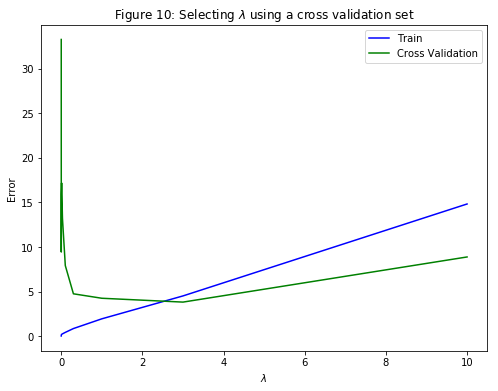

In [11]:
# Create a function to train the model with various values of lambda_coef.
def validationCurve(X, y, Xval, yval):
    """
    Generates the train and validation errors needed to plot a validation
    curve that can be used to select lambda.
    Args:
        X: array (m, number of features+1)
        y: array (m, 1)
        Xval: array (s, number of features+1)
        yval: array (s, 1)
    Returns:
        lambda_vec: array (10,)
        error_train: array (10, 1)
        error_val: array (10, 1)
    """
    # Create a list of 10 selected values of lambda_coef.
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

    # Initialize the errors.
    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))
    
    # Loop over lambda_vec.
    for i in range(len(lambda_vec)):
        lambda_coef = lambda_vec[i]

        # Train the model with current lambda_coef.
        theta = trainLinearReg(X, y, lambda_coef)

        # Get the errors with lambda_coef set to 0!!!
        error_train[i] = linearRegCostFunction(X, y, theta, 0)[0]
        error_val[i] = linearRegCostFunction(Xval, yval, theta, 0)[0]
         
    return lambda_vec, error_train, error_val

lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.figure(figsize=(8, 6))
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.title('Figure 10: Selecting $\lambda$ using a cross validation set')
plt.plot(lambda_vec, error_train, 'b', label='Train')
plt.plot(lambda_vec, error_val, 'g', label='Cross Validation')
plt.legend()

print('lambda\tTrain Error\tValidation Error\n')
for i in range(len(lambda_vec)):
    print('{}\t{}\t{}\n'.format(lambda_vec[i], error_train[i], error_val[i]))

## Computing Test Set Error

Previously, the cross validation error for various values of the regularization parameter $\lambda$ was computed. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “final” model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$).

Now, the test error will be computed using the best value of $\lambda=3$ that was found previously.

In [12]:
# Train the model with the best value of lambda_coef.
theta = trainLinearReg(X_poly, y, 3)

# Get the test error with lambda_coef set to 0!!!
error_test = linearRegCostFunction(X_poly_test, ytest, theta, 0)[0]
print("Test error for the best lambda: {0:.4f}".format(error_test))

Test error for the best lambda: 3.5720


## Plotting Learning Curves with Randomly Selected Examples

In practice, especially for small training sets, when plotting learning curves to debug an algorithm, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for i examples, first i examples from the training set and i examples from the cross validation set should be randomly selected. Then the parameters $\theta$ will be learnt using the randomly chosen training set and will be evaluated on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for i examples.